In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dir = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 7/data'

In [3]:
# prompt: data trong folder với data_path là dir đang chia thành json là label của ảnh đó, chia dữ liệu thành 3 tập train test val

import os
import json
import random
from google.colab import drive

drive.mount('/content/drive')
dir = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 7/data'

def split_data(data_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Splits data into train, validation, and test sets."""

    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("Ratios must sum to 1.0")

    image_files = []
    for filename in os.listdir(data_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')): # Adjust if needed
          image_files.append(filename)

    num_images = len(image_files)
    random.shuffle(image_files)  # Shuffle for randomness

    train_split = int(num_images * train_ratio)
    val_split = int(num_images * (train_ratio + val_ratio))

    train_data = image_files[:train_split]
    val_data = image_files[train_split:val_split]
    test_data = image_files[val_split:]

    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(dir)

print("Number of training images:", len(train_data))
print("Number of validation images:", len(val_data))
print("Number of testing images:", len(test_data))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of training images: 350
Number of validation images: 75
Number of testing images: 75


In [21]:
# prompt: train model để reg 4 điểm xmin,ymin,xmax,ymax

import tensorflow as tf
import numpy as np
from PIL import Image
import json

# Assuming you have a function to load images and annotations
def load_image_and_annotations(image_path):
    try:
        img = Image.open(image_path)
        img = img.resize((224, 224)) # Resize if necessary
        img_array = np.array(img) / 255.0  # Normalize pixel values

        # Extract annotations from a json file or other format
        json_path = image_path[:-4] + ".json" # Assumed json naming convention
        with open(json_path, "r") as f:
            annotations = json.load(f)
        xmin, ymin = annotations['shapes'][0]['points'][0]
        xmax, ymax = annotations['shapes'][0]['points'][1]

        return img_array, [xmin, ymin, xmax, ymax]
    except FileNotFoundError:
        print(f"Annotation file not found for: {image_path}")
        return None, None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

# Prepare data for model training
def prepare_data(image_list, data_dir):
    images = []
    annotations = []
    for image_file in image_list:
        image_path = os.path.join(data_dir, image_file)
        img, ann = load_image_and_annotations(image_path)

        if img is not None and ann is not None:
            images.append(img)
            annotations.append(ann)

    return np.array(images), np.array(annotations)

# Example usage for training set:
train_images, train_annotations = prepare_data(train_data, dir)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)  # Output layer with 4 units for xmin, ymin, xmax, ymax
])

# Compile the model
model.compile(optimizer='adam', loss='mse') # Use Mean Squared Error for regression

# Train the model
model.fit(train_images, train_annotations, epochs=10) # adjust epochs as needed

# You can similarly prepare and use the validation and test data to evaluate your model:
val_images, val_annotations = prepare_data(val_data, dir)
test_images, test_annotations = prepare_data(test_data, dir)

loss = model.evaluate(val_images, val_annotations, verbose=0)
print(f'Validation Loss: {loss}')

loss = model.evaluate(test_images, test_annotations, verbose=0)
print(f'Test Loss: {loss}')


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (350, 224, 224) + inhomogeneous part.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


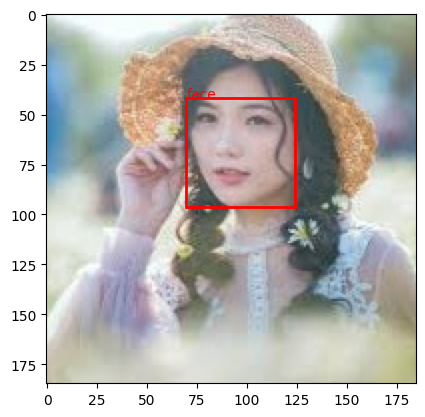

In [10]:
# prompt: visualize 1 tấm với file json chứa bouding box của tấm đó với cấu trúc file json là: {'version': '0.4.16',
#  'flags': {},
#  'shapes': [{'label': 'face',
#    'text': '',
#    'points': [[69.70739219712526, 41.781314168377826],
#     [124.12217659137578, 96.40143737166323]],
#    'group_id': None,
#    'shape_type': 'rectangle',
#    'flags': {}}],
#  'imagePath': 'image_222.jpg',
#  'imageData': None,
#  'imageHeight': 185,
#  'imageWidth': 185}

from google.colab import drive
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

drive.mount('/content/drive')
dir = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 7/data'

def visualize_image_with_bbox(image_path, json_path):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: JSON file not found at {json_path}")
        return
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {json_path}")
        return

    try:
        img = Image.open(image_path)
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for shape in data['shapes']:
        if shape['shape_type'] == 'rectangle':
            xmin, ymin = shape['points'][0]
            xmax, ymax = shape['points'][1]
            width = xmax - xmin
            height = ymax - ymin

            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, shape['label'], color='red')

    plt.show()

# Example usage (replace with actual paths)
image_file = 'image_222.jpg' # Replace with the actual image filename
json_file = 'image_222.json'  # Replace with the actual JSON filename

image_path = os.path.join(dir, image_file)
json_path = os.path.join(dir, json_file)

visualize_image_with_bbox(image_path, json_path)


In [23]:
import torch

def collate_fn(batch):
    """
    Collate function for object detection models.
    It ensures that images and targets are returned as tuples.
    """
    images = []
    targets = []
    for img, tgt in batch:
        images.append(img)
        targets.append(tgt)
    return images, targets


In [22]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms.v2 import functional as F, Transform, Compose, ToImage, ToDtype
from torch.utils.data import Dataset, DataLoader
import json
import os
from PIL import Image
import numpy as np
import utils # Cần file utils.py từ repo torchvision hoặc tự định nghĩa collate_fn

# --- Cấu hình ---
# !!! THAY ĐỔI CÁC ĐƯỜNG DẪN VÀ THAM SỐ NÀY CHO PHÙ HỢP !!!
IMAGE_DIR = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 7/data' # Ví dụ: '/path/to/your/data'
ANNOTATION_DIR = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 7/data' # Ví dụ: '/path/to/your/data'
MODEL_SAVE_PATH = 'localization_model.pth'
NUM_CLASSES = 3 # !!! SỐ LỚP ĐỐI TƯỢNG + 1 (BACKGROUND) !!! Ví dụ: Nếu có 'cat', 'dog' -> NUM_CLASSES = 3
BATCH_SIZE = 2
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# --- Định nghĩa Dataset ---
class CustomDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        # Lấy danh sách file, bỏ phần mở rộng để khớp ảnh và json
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.json_files = sorted([f for f in os.listdir(annotation_dir) if f.endswith('.json')])

        # Đảm bảo số lượng file khớp nhau và tên gốc khớp nhau
        img_stems = {os.path.splitext(f)[0] for f in self.image_files}
        json_stems = {os.path.splitext(f)[0] for f in self.json_files}
        if img_stems != json_stems:
            print("Cảnh báo: Danh sách file ảnh và JSON không khớp hoàn toàn!")
            # Lấy phần giao nhau để tránh lỗi
            common_stems = list(img_stems.intersection(json_stems))
            self.image_files = [f"{stem}.jpg" for stem in common_stems]
            self.json_files = [f"{stem}.json" for stem in common_stems]
            print(f"Sử dụng {len(self.image_files)} cặp file khớp nhau.")

        # !!! QUAN TRỌNG: Ánh xạ tên lớp sang số nguyên !!!
        # Bạn cần định nghĩa ánh xạ này dựa trên các label trong file JSON
        self.class_to_int = {'background': 0} # Background luôn là 0
        # Ví dụ: self.class_to_int = {'background': 0, 'cat': 1, 'dog': 2}
        # Tự động tìm các lớp nếu chưa định nghĩa (cần chạy qua dữ liệu 1 lần)
        all_labels = set()
        for json_file in self.json_files:
            json_path = os.path.join(self.annotation_dir, json_file)
            try:
                with open(json_path, 'r') as f:
                    data = json.load(f)
                    # !!! GIẢ ĐỊNH CẤU TRÚC JSON !!!
                    # Giả định data là list các dict, mỗi dict có key 'label'
                    if isinstance(data, list):
                       for item in data:
                           if 'label' in item:
                               all_labels.add(item['label'])
                    # Thêm các cấu trúc khác nếu cần
            except Exception as e:
                 print(f"Lỗi đọc {json_path}: {e}")

        current_idx = 1
        for label in sorted(list(all_labels)):
             if label not in self.class_to_int:
                 self.class_to_int[label] = current_idx
                 current_idx += 1

        print("Ánh xạ lớp:", self.class_to_int)
        if len(self.class_to_int) != NUM_CLASSES:
             print(f"Cảnh báo: NUM_CLASSES ({NUM_CLASSES}) không khớp số lớp tìm thấy ({len(self.class_to_int)})!")


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        json_name = self.json_files[idx] # Đảm bảo đã sort giống nhau

        img_path = os.path.join(self.image_dir, img_name)
        json_path = os.path.join(self.annotation_dir, json_name)

        # Đọc ảnh
        img = Image.open(img_path).convert("RGB")

        # Đọc và xử lý JSON
        boxes = []
        labels = []
        try:
            with open(json_path, 'r') as f:
                annotations = json.load(f)
                # --- !!! PHẦN CẦN ĐIỀU CHỈNH THEO CẤU TRÚC JSON CỦA BẠN !!! ---
                # Giả định annotations là một list các dictionaries
                # Mỗi dictionary có key 'label' và 'bbox' là [xmin, ymin, xmax, ymax]
                if isinstance(annotations, list):
                    for obj in annotations:
                        # Lấy tọa độ bounding box
                        # Đảm bảo đúng định dạng [xmin, ymin, xmax, ymax]
                        bbox = obj.get('bbox', None) # Hoặc key tương ứng trong file json
                        label = obj.get('label', None) # Hoặc key tương ứng

                        if bbox is not None and label is not None and label in self.class_to_int:
                             # Kiểm tra tính hợp lệ của bbox (xmin < xmax, ymin < ymax)
                            if bbox[0] < bbox[2] and bbox[1] < bbox[3]:
                                boxes.append(bbox)
                                labels.append(self.class_to_int[label])
                            else:
                                print(f"Cảnh báo: Bounding box không hợp lệ trong {json_name}: {bbox}")
                        # else:
                        #     print(f"Cảnh báo: Thiếu 'bbox' hoặc 'label' hoặc label không có trong ánh xạ trong {json_name}")

                # --- Kết thúc phần cần điều chỉnh ---
        except Exception as e:
            print(f"Lỗi xử lý file {json_path}: {e}")
            # Trả về ảnh không có box nếu lỗi đọc JSON
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)


        # Chuyển đổi sang Tensor
        if boxes:
             boxes = torch.tensor(boxes, dtype=torch.float32)
             labels = torch.tensor(labels, dtype=torch.int64)
        else: # Trường hợp không có object nào hoặc lỗi đọc JSON
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # Thêm các thông tin khác nếu model yêu cầu (area, iscrowd)
        target["image_id"] = torch.tensor([idx])
        if boxes.shape[0] > 0:
            target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            target["area"] = torch.tensor([], dtype=torch.float32)
        target["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)


        # Áp dụng transforms
        if self.transforms:
             # torchvision transforms v2 cần cả img và target
            img, target = self.transforms(img, target)
        else:
            # Nếu không có transform, tự chuyển ảnh sang tensor
            img = F.to_image(img) # Chuyển PIL Image thành tensor nếu không dùng transforms
            img = F.to_dtype(img, torch.float32, scale=True) # Chuẩn hóa về [0.0, 1.0]


        return img, target

# --- Định nghĩa Transforms ---
# Sử dụng transforms v2 của torchvision
def get_transform(train):
    transforms = []
    transforms.append(ToImage()) # Chuyển PIL image thành Tensor
    transforms.append(ToDtype(torch.float32, scale=True)) # Chuẩn hóa về [0.0, 1.0]
    # Thêm các augmentation khác nếu là training (ví dụ: RandomHorizontalFlip)
    # if train:
    #     transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)


# --- Định nghĩa Model ---
def get_model(num_classes):
    # Load một model pre-trained trên COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    # Lấy số lượng input features cho classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Thay thế head bằng một head mới phù hợp với số lớp của bạn
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

# --- Hàm tiện ích (Collate Function) ---
# Cần thiết cho DataLoader khi làm việc với object detection targets (là list các dict)
# Lấy từ repo Pytorch Vision: https://github.com/pytorch/vision/blob/main/references/detection/utils.py
# Hoặc định nghĩa đơn giản:
def collate_fn(batch):
    return tuple(zip(*batch))

# --- Hàm Huấn luyện ---
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train() # Chuyển model sang chế độ train
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        # lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)
        # Thay bằng warmup thủ công nếu cần đơn giản hơn

    running_loss = 0.0
    processed_batches = 0
    print_freq = 10 # In loss sau mỗi 10 batch

    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Tính loss (model trả về dict các loss khi ở chế độ train)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Check loss hợp lệ
        if not torch.isfinite(losses):
            print(f"!!! Lỗi: Loss không hợp lệ: {losses.item()}. Bỏ qua batch này.")
            print("Loss dict:", loss_dict)
            # Có thể cần xem xét dừng training hoặc giảm learning rate
            continue # Bỏ qua bước cập nhật này

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Cập nhật learning rate (nếu có scheduler)
        # if lr_scheduler is not None:
        #     lr_scheduler.step()

        running_loss += losses.item()
        processed_batches += 1

        if (i + 1) % print_freq == 0:
             print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{i+1}/{len(data_loader)}], Loss: {losses.item():.4f}, Avg Loss: {running_loss/processed_batches:.4f}')

    avg_epoch_loss = running_loss / processed_batches if processed_batches > 0 else 0
    print(f"--- Kết thúc Epoch {epoch+1} --- Avg Loss: {avg_epoch_loss:.4f} ---")
    return avg_epoch_loss


# --- Main Training Script ---
if __name__ == '__main__':
    # --- Khởi tạo Dataset và DataLoader ---
    print("Khởi tạo dataset...")
    dataset = CustomDataset(IMAGE_DIR, ANNOTATION_DIR, transforms=get_transform(train=True))
    # dataset_test = CustomDataset(IMAGE_DIR, ANNOTATION_DIR, transforms=get_transform(train=False)) # Có thể tạo bộ test riêng

    # Chia dataset (ví dụ: 80% train, 20% val - tùy chọn)
    # torch.manual_seed(1)
    # indices = torch.randperm(len(dataset)).tolist()
    # dataset = torch.utils.data.Subset(dataset, indices[:-50]) # Ví dụ giữ lại 50 sample cho test
    # dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    data_loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2, # Điều chỉnh số worker tùy theo CPU
        collate_fn=collate_fn # !! Quan trọng !!
    )

    # data_loader_test = DataLoader(
    #     dataset_test, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

    print(f"Đã load {len(dataset)} samples cho training.")

    # --- Khởi tạo Model ---
    print(f"Khởi tạo model Faster R-CNN với {NUM_CLASSES} lớp (bao gồm background)...")
    model = get_model(NUM_CLASSES)
    model.to(DEVICE)
    print("Model đã được chuyển tới:", DEVICE)

    # --- Khởi tạo Optimizer ---
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
    # Có thể thử Adam: optimizer = torch.optim.Adam(params, lr=LEARNING_RATE)

    # --- Vòng lặp Huấn luyện ---
    print("Bắt đầu huấn luyện...")
    for epoch in range(NUM_EPOCHS):
        train_one_epoch(model, optimizer, data_loader, DEVICE, epoch)
        # Có thể thêm bước validation ở đây nếu có dataset_test và data_loader_test
        # evaluate(model, data_loader_test, device=device) # Cần hàm evaluate riêng

    print("Hoàn thành huấn luyện!")

    # --- Lưu Model ---
    print(f"Lưu model vào {MODEL_SAVE_PATH}...")
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print("Đã lưu model.")

    # --- Lưu ánh xạ lớp (quan trọng cho demo) ---
    class_mapping_path = 'class_mapping.json'
    # Tạo map ngược từ int -> label để dễ hiển thị
    int_to_class = {v: k for k, v in dataset.class_to_int.items()}
    with open(class_mapping_path, 'w') as f:
        json.dump(int_to_class, f)
    print(f"Đã lưu ánh xạ lớp vào {class_mapping_path}")

ModuleNotFoundError: No module named 'utils'